In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import os
import glob
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import numpy as np
import argparse
import seaborn as sns

In [ ]:
import pandas as pd
import numpy as np
movies = pd.read_csv("/content/drive/MyDrive/ml-25m/movies.csv",usecols=['movieId','title','genres'],dtype = {'movieId':'int32', 'title':'str','genres':'str'})
Ratings = pd.read_csv("/content/drive/MyDrive/ml-25m/ratings.csv",usecols = ['userId', 'movieId', 'rating'],dtype={'userId': 'int32', 'movieId': 'int32', 'rating': 'float32'})
Tags = pd.read_csv("/content/drive/MyDrive/ml-25m/tags.csv",usecols=['userId','movieId','tag'])
links = pd.read_csv("/content/drive/MyDrive/ml-25m/links.csv")
gtags = pd.read_csv("/content/drive/MyDrive/ml-25m/genome-tags.csv")
gscore = pd.read_csv("/content/drive/MyDrive/ml-25m/genome-scores.csv")

In [ ]:
gtags.shape,gscore.shape,links.shape,Tags.shape,Ratings.shape,movies.shape

((1128, 2), (15584448, 3), (62423, 3), (1093360, 3), (25000095, 3), (62423, 3))

In [ ]:
print("Total number of movies =", movies.shape[0])
print("Total number of unique movies =", len(movies.movieId.unique()))
print("")
print("Total number of user ratings =", Ratings.shape[0])
print("Total number of unique users =", len(Ratings.userId.unique()))

Total number of movies = 62423
Total number of unique movies = 62423

Total number of user ratings = 25000095
Total number of unique users = 162541


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


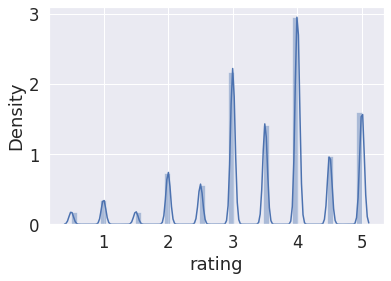

In [ ]:
import seaborn as sns
sns.set_style('whitegrid')
sns.set(font_scale=1.5)
%matplotlib inline
sns.distplot(Ratings['rating'].fillna(Ratings['rating'].median()))

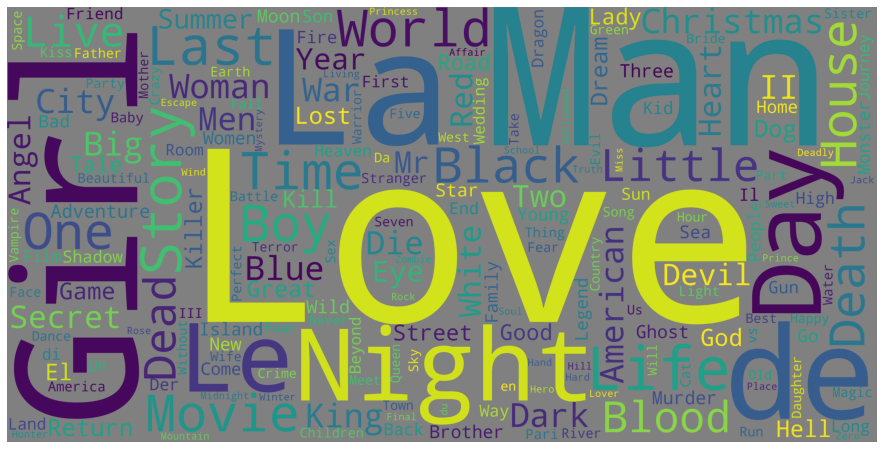

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import wordcloud
from wordcloud import WordCloud, STOPWORDS
movies['title'] = movies['title'].fillna("").astype('str')
title_corpus = ' '.join(movies['title'])
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='grey', height=2000, width=4000).generate(title_corpus)
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

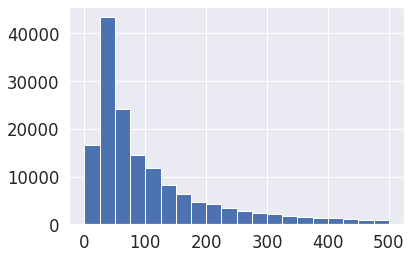

In [ ]:
import statistics
ratings_per_user = Ratings.groupby('userId')['rating'].count()
statistics.mean(ratings_per_user.tolist())
import matplotlib.pyplot as plt
%matplotlib inline
ratings_per_user.hist(bins=20, range=(0,500))

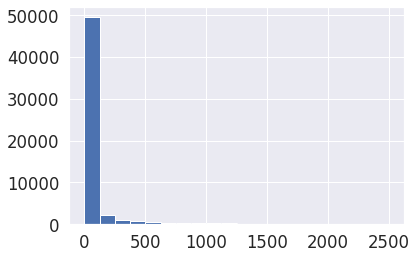

In [ ]:
ratings_per_movie = Ratings.groupby('movieId')['rating'].count()
statistics.mean(ratings_per_movie.tolist())
ratings_per_movie.hist(bins=20, range=(0,2500))

In [ ]:
genre_labels = set()
for s in movies['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))

# Function that counts the number of times each of the genre keywords appear
def count_word(dataset, ref_col, census):
    keyword_count = dict()
    for s in census: 
        keyword_count[s] = 0
    for census_keywords in dataset[ref_col].str.split('|'):        
        if type(census_keywords) == float and pd.isnull(census_keywords): 
            continue        
        for s in [s for s in census_keywords if s in census]: 
            if pd.notnull(s): 
                keyword_count[s] += 1
    #______________________________________________________________________
    # convert the dictionary in a list to sort the keywords by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

# Calling this function gives access to a list of genre keywords which are sorted by decreasing frequency
keyword_occurences, dum = count_word(movies, 'genres', genre_labels)
keyword_occurences[:5]

[['Drama', 25606],
 ['Comedy', 16870],
 ['Thriller', 8654],
 ['Romance', 7719],
 ['Action', 7348]]

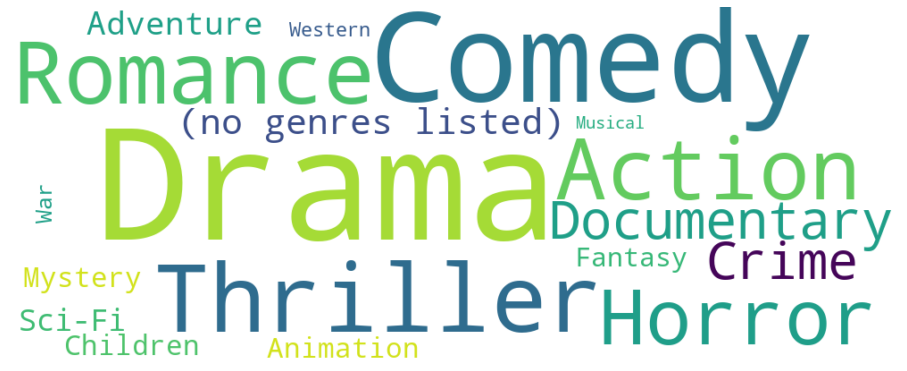

In [ ]:
genres = dict()
trunc_occurences = keyword_occurences[0:18]
for s in trunc_occurences:
    genres[s[0]] = s[1]

# Create the wordcloud
genre_wordcloud = WordCloud(width=1000,height=400, background_color='white')
genre_wordcloud.generate_from_frequencies(genres)

# Plot the wordcloud
f, ax = plt.subplots(figsize=(16, 8))
plt.imshow(genre_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


In [ ]:
action_movies = ['American Made', 'The Dictator', 
                     'Civil War:Avengers', 'Star Wars: Episode V - The Empire Strikes Back',
                     'IronMan']
romantic_movies = ['Notting Hill', 'Love Story \(1970\)', 'When Harry Met Sally',
                       'Titanic \(1997\)', 'Pretty Woman']

top_movies = action_movies + romantic_movies

movie_data = movies[movies.title.str.contains('|'.join(top_movies))]
movie_data

,movieId,title,genres
589,597,Pretty Woman (1990),Comedy|Romance
1166,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi
1273,1307,When Harry Met Sally... (1989),Comedy|Romance
1655,1721,Titanic (1997),Drama|Romance
2579,2671,Notting Hill (1999),Comedy|Romance
4191,4296,Love Story (1970),Drama|Romance
22447,114922,Ratko: The Dictator's Son (National Lampoon's ...,Comedy
48486,176751,American Made (2017),Crime|Thriller


In [ ]:
rating_data = Ratings.iloc[:, :]

In [ ]:
movie_rating_merged_data = movie_data.merge(rating_data, on='movieId', how='inner')
movie_rating_merged_data.head()

,movieId,title,genres,userId,rating
0,597,Pretty Woman (1990),Comedy|Romance,9,5.0
1,597,Pretty Woman (1990),Comedy|Romance,18,3.0
2,597,Pretty Woman (1990),Comedy|Romance,23,3.0
3,597,Pretty Woman (1990),Comedy|Romance,27,5.0
4,597,Pretty Woman (1990),Comedy|Romance,31,3.0


In [ ]:
movie_rating_merged_data[movie_rating_merged_data.title == 'Pretty Woman (1990)']['rating'].mean()

3.4264912605285645

In [ ]:
movie_rating_merged_data.groupby(['title'], sort=False)['rating'].mean().sort_values(ascending=False).head(10)

title
Star Wars: Episode V - The Empire Strikes Back (1980)                              4.144122
When Harry Met Sally... (1989)                                                     3.831802
American Made (2017)                                                               3.654867
Notting Hill (1999)                                                                3.458825
Pretty Woman (1990)                                                                3.426491
Titanic (1997)                                                                     3.381152
Love Story (1970)                                                                  3.186023
Ratko: The Dictator's Son (National Lampoon's Ratko: The Dictator's Son) (2009)    2.500000
Name: rating, dtype: float32

In [ ]:
movies = movies.dropna(axis=1)
merged = movies.merge(Ratings, on='movieId')
merged.to_csv("combined_movies_rating.csv", index=False)

In [ ]:
combined_data = pd.read_csv('combined_movies_rating.csv')

In [ ]:
combined_data.head()

,movieId,title,genres,userId,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2,3.5
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3,4.0
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4,3.0
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,8,4.0


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import numpy as np
import argparse
def sigmoid(x):
	return 1.0 / (1 + np.exp(-x))
def sigmoid_derivative(x):
	return x * (1 - x)

In [ ]:
def predict(X, W):
	preds = sigmoid(X.dot(W))
	preds[preds <= 0.5] = 0
	preds[preds > 0] = 1
	return preds

In [ ]:
def next_batch(X, y, batchSize):
	for i in np.arange(0, X.shape[0], batchSize):
		yield (X[i:i + batchSize], y[i:i + batchSize])

In [ ]:
import sys
ap = argparse.ArgumentParser()
ap.add_argument("-e", "--epochs", type=float, default=500,
	help="# of epochs")
ap.add_argument("-a", "--alpha", type=float, default=0.01,
	help="learning rate")
ap.add_argument("-b", "--batch-size", type=int, default=32,
	help="size of SGD mini-batches")
sys.argv=['']
del sys
args = vars(ap.parse_args())

In [ ]:
from sklearn.model_selection import train_test_split
X, y = train_test_split(combined_data)

In [ ]:
(X, y) = make_blobs(n_samples=100000, n_features=3, centers=2,
	cluster_std=1.5, random_state=1)
y = y.reshape((y.shape[0], 1))
X = np.c_[X, np.ones((X.shape[0]))]
(trainX, testX, trainY, testY) = train_test_split(X, y,
	test_size=0.5, random_state=42)

In [ ]:
W = np.random.randn(X.shape[1], 1)
losses = []

In [ ]:
for epoch in np.arange(0, args["epochs"]):
	epochLoss = []
	for (batchX, batchY) in next_batch(trainX, trainY, args["batch_size"]):
		preds = sigmoid(batchX.dot(W))
		error = preds - batchY
		epochLoss.append(np.sum(error ** 2))
		d = error * sigmoid_derivative(preds)
		gradient = batchX.T.dot(d)
		W += -args["alpha"] * gradient
		loss=np.average(epochLoss)
		losses.append(loss)		# check to see if an update should be displayed
		if epoch == 0 or (epoch + 1) % 5 == 0:
		  print("[INFO] epoch={}, loss={:.7f}".format(int(epoch + 1),loss))

Streaming output truncated to the last 5000 lines.
[INFO] epoch=485, loss=0.0005443
[INFO] epoch=485, loss=0.0005439
[INFO] epoch=485, loss=0.0005435
[INFO] epoch=485, loss=0.0005430
[INFO] epoch=485, loss=0.0005428
[INFO] epoch=485, loss=0.0005424
[INFO] epoch=485, loss=0.0005419
[INFO] epoch=485, loss=0.0005415
[INFO] epoch=485, loss=0.0005411
[INFO] epoch=485, loss=0.0005406
[INFO] epoch=485, loss=0.0005402
[INFO] epoch=485, loss=0.0005398
[INFO] epoch=485, loss=0.0005394
[INFO] epoch=485, loss=0.0005389
[INFO] epoch=485, loss=0.0005385
[INFO] epoch=485, loss=0.0005381
[INFO] epoch=485, loss=0.0005377
[INFO] epoch=485, loss=0.0005372
[INFO] epoch=485, loss=0.0005368
[INFO] epoch=485, loss=0.0005364
[INFO] epoch=485, loss=0.0005360
[INFO] epoch=485, loss=0.0005356
[INFO] epoch=485, loss=0.0005351
[INFO] epoch=485, loss=0.0005347
[INFO] epoch=485, loss=0.0005343
[INFO] epoch=485, loss=0.0005339
[INFO] epoch=485, loss=0.0005335
[INFO] epoch=485, loss=0.0005330
[INFO] epoch=485, loss=0.

In [ ]:
movie_rating_merged_pivot = pd.pivot_table(movie_rating_merged_data,
                                           index=['title'],
                                           columns=['userId'],
                                           values=['rating'],
                                           dropna=False,
                                           fill_value=0
                                          )
movie_rating_merged_pivot.shape

(8, 91977)

In [ ]:
Y = movie_rating_merged_pivot

In [ ]:
Y

rating         ...              
userId                                             2      3       ... 162540 162541
title                                                             ...              
American Made (2017)                                    0      0  ...      0      0
Love Story (1970)                                       0      0  ...      0      0
Notting Hill (1999)                                     0      0  ...      0      0
Pretty Woman (1990)                                     0      0  ...      0      0
Ratko: The Dictator's Son (National Lampoon's R...      0      0  ...      0      0
Star Wars: Episode V - The Empire Strikes Back ...      5      4  ...      0      5
Titanic (1997)                                          0      0  ...      5      0
When Harry Met Sally... (1989)                          0      0  ...      0      0

[8 rows x 91977 columns]

In [ ]:
R = np.ones(Y.shape)
no_rating_idx = np.where(Y == 0.0)
R[no_rating_idx] = 0
R

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 1., 0., 1.],
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
n_u = Y.shape[1]
n_m = Y.shape[0]
n_f = 3

In [ ]:
np.random.seed(7)
Initial_X = np.random.rand(n_m, n_f)
Initial_Theta = np.random.rand(n_u, n_f)

In [ ]:
def collabFilterCostFunction(X, Theta, Y, R, reg_lambda):
    cost = 0
    error = (np.dot(X, Theta.T) - Y) * R
    error_sq = np.power(error, 2)
    cost = np.sum(np.sum(error_sq)) / 2
    cost = cost + ((reg_lambda/2) * ( np.sum(np.sum((np.power(X, 2)))) + np.sum(np.sum((np.power(Theta, 2))))))
    return cost

In [ ]:
def collabFilterGradientDescent(X, Theta, Y, R, alpha, reg_lambda, num_iters):
    cost_history = np.zeros([num_iters, 1])
    
    for i in range(num_iters):
        error = (np.dot(X, Theta.T) - Y) * R
        X_grad = np.dot(error, Theta) + reg_lambda * X
        Theta_grad = np.dot(error.T, X) + reg_lambda * Theta
        
        X = X - alpha * X_grad 
        Theta = Theta - alpha * Theta_grad
        
        cost_history[i] = collabFilterCostFunction(X, Theta, Y, R, reg_lambda)
        
    return X, Theta, cost_history

In [ ]:
alpha = 0.0001
num_iters = 5
reg_lambda = 1

X, Theta = Initial_X, Initial_Theta
X, Theta, cost_history = collabFilterGradientDescent(X, Theta, Y, R, alpha, reg_lambda, num_iters)
cost = collabFilterCostFunction(X, Theta, Y, R, reg_lambda)
print("Final cost =", cost)

Final cost = 38205340290800.24


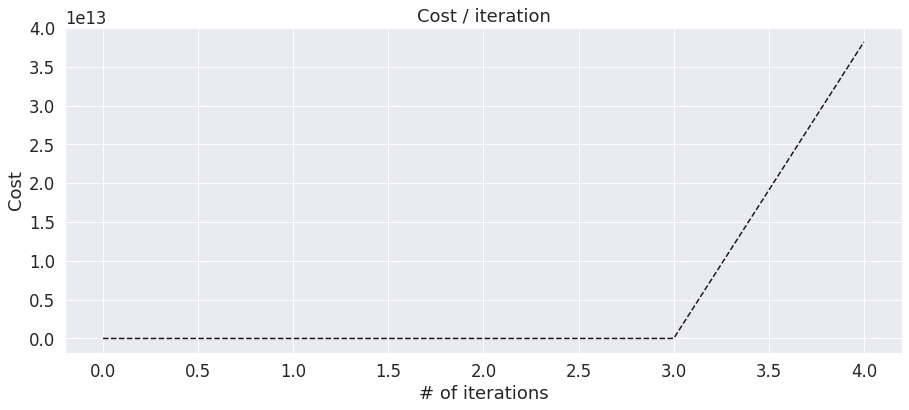

In [ ]:
fig, axes = plt.subplots(figsize=(15,6))
axes.plot(cost_history, 'k--')
axes.set_xlabel('# of iterations')
axes.set_ylabel('Cost')
axes.set_title('Cost / iteration')
plt.show()

In [ ]:
user_idx = np.random.randint(n_u)
pred_rating = []
print("Original rating of an user:\n", Y.iloc[:,user_idx].sort_values(ascending=False))

predicted_ratings = np.dot(X, Theta.T)
predicted_ratings = sorted(zip(predicted_ratings[:,user_idx], Y.index), reverse=True)
print("\nPredicted rating of the same user:")
_ = [print(rating, movie) for rating, movie in predicted_ratings]

Original rating of an user:
 title
Titanic (1997)                                                                     2
When Harry Met Sally... (1989)                                                     0
Star Wars: Episode V - The Empire Strikes Back (1980)                              0
Ratko: The Dictator's Son (National Lampoon's Ratko: The Dictator's Son) (2009)    0
Pretty Woman (1990)                                                                0
Notting Hill (1999)                                                                0
Love Story (1970)                                                                  0
American Made (2017)                                                               0
Name: (rating, 92569), dtype: int64

Predicted rating of the same user:
1996.4127955887313 Star Wars: Episode V - The Empire Strikes Back (1980)
76.37031289540884 Titanic (1997)
30.895785146912147 Pretty Woman (1990)
0.8802830683020482 Love Story (1970)
0.8786083879577181 American Mad

In [ ]:
!pip install surprise
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
reader = Reader()
combined_data.head(5)

,movieId,title,genres,userId,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2,3.5
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3,4.0
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4,3.0
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,8,4.0


In [ ]:
df4 = pd.read_csv('combined_movies_rating.csv', nrows=12000000)

In [ ]:
data = Dataset.load_from_df(df4[['movieId', 'userId', 'rating']], reader)

In [ ]:
svd = SVD()
cross_validate(svd, data, measures=['RMSE'], cv=5)

{'fit_time': (765.0359189510345,
  796.4300999641418,
  775.3696224689484,
  788.592166185379,
  779.6791059970856),
 'test_rmse': array([0.79747978, 0.79680464, 0.79795733, 0.7973153 , 0.79748261]),
 'test_time': (76.47688245773315,
  71.91961693763733,
  64.2422423362732,
  80.49298524856567,
  66.96273827552795)}

In [ ]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [ ]:
import pickle
pickle.dump(SVD, open('movie_recommendation.pkl', 'wb'))

In [ ]:
combined_data.to_csv("combined_data_new.csv", index=False)